# Analysis of particles in analytical flows
In this notebook we analyise intertial and tracer particles simulated using parcels in the following flow fields: 
- 2D kaufmann vortex flow
- 3D vortex symmetric/asymmetric flow



In [8]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from decimal import Decimal
import plotly.express as px # for 3d plotting

plt.style.use('../python_style_Meike.mplstyle')

#set base directory
base_directory='/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/'


## 2D Kaufmann vortex   

### Tracer particles

In [9]:
# set directories 
input_directory_particles = base_directory + 'particle_simulations/'
input_files_particles = 'tracer_particle_kaufmann_2D_RK4.zarr'

input_file_flow = base_directory + 'fieldsets/kaufmann_vortex_field.nc' 

# read in tracer particles trajectories 
datasettracer = {}
datasettracer = xr.open_zarr(input_directory_particles + input_files_particles)
flowset = xr.open_dataset(input_file_flow)

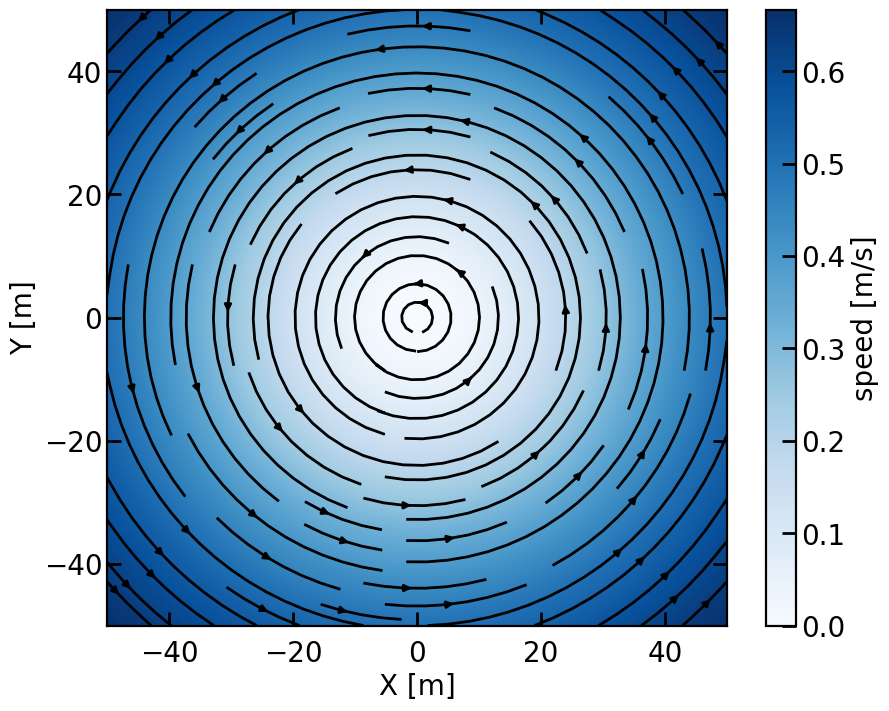

In [10]:
#plot analytical flow
fig,ax = plt.subplots()
lonsflow = flowset['lon'].values
latsflow = flowset['lat'].values
longrid, latsgrid =  np.meshgrid(lonsflow, latsflow)
Uflow = flowset['U'][0, :, :].values
Vflow = flowset['V'][0, :, :].values

ax.streamplot(longrid, latsgrid, Uflow, Vflow, color='k')
pcm = ax.pcolormesh(longrid, latsgrid, np.sqrt(Uflow**2 + Vflow**2), cmap='Blues')
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
cbar = fig.colorbar(pcm, label='speed [m/s]')



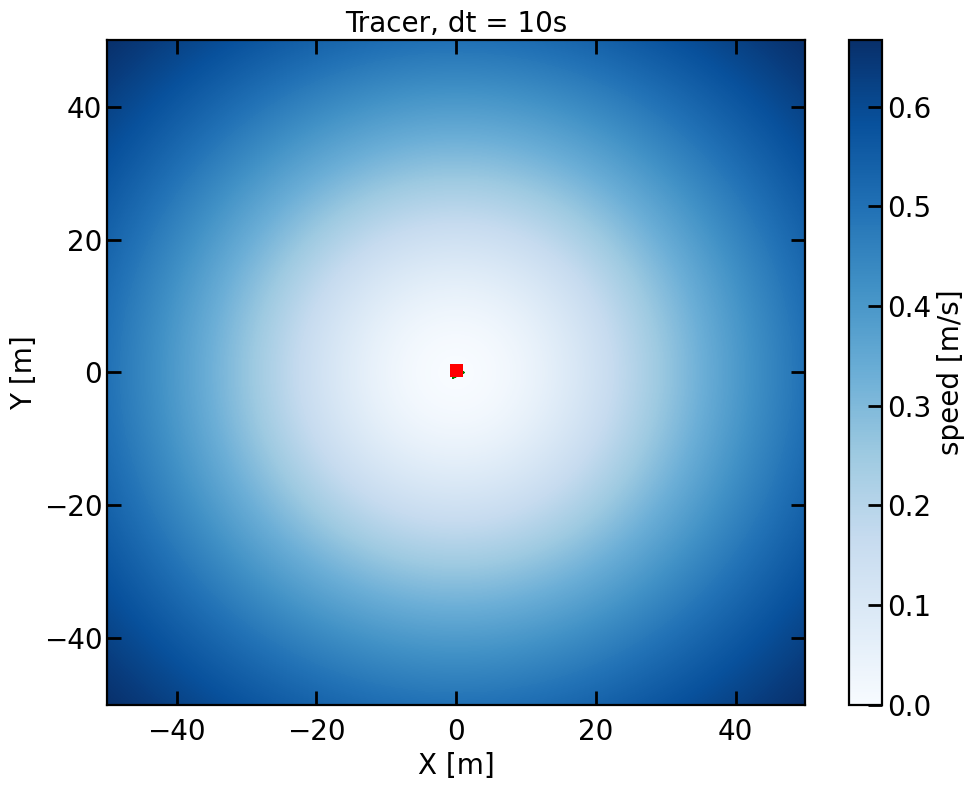

In [11]:
#plot trajectory tracer particles together with background flow
lonp = datasettracer['lon'].values
latp = datasettracer['lat'].values
runtime = float(datasettracer.attrs['runtime'])
dtwrite = float(datasettracer.attrs['write_dt'])
tmax = int(runtime/dtwrite) - 1

fig ,ax = plt.subplots()
ax.plot(lonp[:, :tmax+1].T, latp[:, :tmax+1].T, color='black')
ax.plot(lonp[:,0].T, latp[:,0].T, '>', color='green')
ax.plot(lonp[:,tmax].T, latp[:,tmax].T, 's', color='red')
pcm = ax.pcolormesh(longrid, latsgrid, np.sqrt(Uflow**2 + Vflow**2), cmap='Blues')
ax.set_ylim(-50, 50)
ax.set_xlim(-50, 50)
cbar = fig.colorbar(pcm, label='speed [m/s]')
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title('Tracer, dt = 10s',fontsize=20)
fig.tight_layout()
fig.savefig('../figures/tracer_advection_kaufmann_RK.pdf')



#### Conclusion testing timestepping tracer particles
I did perform several simulations with different settings, and the timestepping determines  
how well the particle follows the field. The RK4 outperforms the EE: dt=2 still works for RK4  
while for EE to work we need max dt=0.02 for EE, and still there is some drift at this value.

### Inertial particles 

In [ ]:
# read in particles trajectories advected using (1) the full MR equations and  (2) slow manifold MR equations 
datasetMR = {} # simulation data particles advected with the full MR eqauations 

names = np.array(['inertial_particle_kaufmann_2D_RK4_B0800_tau1E+0.zarr',
                  'inertial_particle_kaufmann_2D_RK4_B1000_tau1E+0.zarr',
                  'inertial_particle_kaufmann_2D_RK4_B1200_tau1E+0.zarr', 
                  'inertial_particle_kaufmann_2D_RK4_B0800_tau1E-1.zarr',
                  'inertial_particle_kaufmann_2D_RK4_B1000_tau1E-1.zarr',
                  'inertial_particle_kaufmann_2D_RK4_B1200_tau1E-1.zarr'
                  ])

for i in range(len(names)):
    datasetMR[i]=xr.open_zarr(input_directory_particles+names[i])#,decode_times=False)

    datasetMRSM={}

namesSM = np.array(['inertial_SM_particle_kaufmann_2D_RK4_B0800_tau1E+0.zarr',
                    'inertial_SM_particle_kaufmann_2D_RK4_B1000_tau1E+0.zarr',
                    'inertial_SM_particle_kaufmann_2D_RK4_B1200_tau1E+0.zarr', 
                    'inertial_SM_particle_kaufmann_2D_RK4_B0800_tau1E-1.zarr',
                    'inertial_SM_particle_kaufmann_2D_RK4_B1000_tau1E-1.zarr',
                    'inertial_SM_particle_kaufmann_2D_RK4_B1200_tau1E-1.zarr'
                  ])

for i in range(len(namesSM)):
    datasetMRSM[i]=xr.open_zarr(input_directory_particles+namesSM[i])#,decode_times=False)

In [ ]:
## plot trajectories for the full MR equations for B = 0.8, 1.0, 1.2 and tau = 0.1 and 1. All advected with the RK4 ODE2 scheme
fig,axs = plt.subplots(2,3,figsize=(30,20))
n = 0
m = 0

nparticles=datasetMR[0].attrs['nparticles']
cmap = plt.get_cmap('Grays')
greyarray = cmap(np.linspace(0.1,1,nparticles))

tau = np.array(['MR, $\\tau=1$s, dt=2 s', 'MR, $\\tau=0.1$s, dt=0.2s'])
letters = np.array(['(a)','(b)','(c)','(d)','(e)','(f)'])
Barray = np.array([0.8,1.0,1.2])

for i in range(len(names)): 
    runtime = float(datasetMR[i].attrs['runtime'])
    dtwrite = float(datasetMR[i].attrs['write_dt'])
    tmax = int(runtime/dtwrite)

    lonp = datasetMR[i]['lon'][:,:tmax].values
    latp = datasetMR[i]['lat'][:,:tmax].values

    for j in range(nparticles):
        axs[m,n].plot(lonp[j], latp[j], color=greyarray[j], zorder=-20)
    axs[m,n].plot(lonp[:,0].T, latp[:,0].T, '>', color='green')
    axs[m,n].plot(lonp[:,-1].T, latp[:,-1].T, 's',color='red')
    axs[m,n].set_title(tau[m]+", B={:.02f}".format(Barray[n]),fontsize=20)
    axs[m,n].set_xlabel('X')
    axs[m,n].set_ylabel('Y')
    axs[m,n].text(-47, -47, letters[i], fontsize=30)
    axs[m,n].set_xlim(-50, 50)
    axs[m,n].set_ylim(-50, 50)
    n+=1
    if(n%3==0):
        n=0
        m+=1

fig.tight_layout()
# fig.savefig('../figures/MR_advection_kaufmann_2D_RK4_B0800-1200_tau1E-1-E1+0.pdf')

In [ ]:
## plot trajectories for the slow manifold approximation MR equations for B = 0.8, 1.0, 1.2 and tau = 0.1 and 1. All advected with the RK4 ODE1 scheme
fig,axs = plt.subplots(2, 3, figsize=(30,20))
n=0
m=0

nparticles = datasetMRSM[0].attrs['nparticles']
cmap = plt.get_cmap('Grays')
greyarray = cmap(np.linspace(0.1, 1, nparticles))

tau = np.array(['MR slow manifold, $\\tau=1$s, dt=10 s', 'MR slow manifold, $\\tau=0.1$s, dt=10s'])
letters = np.array(['(a)','(b)','(c)','(d)','(e)','(f)'])
Barray = np.array([0.8,1.0,1.2])

for i in range(len(names)): 
    runtime = float(datasetMRSM[i].attrs['runtime'])
    dtwrite = float(datasetMRSM[i].attrs['write_dt'])
    tmax = int(runtime/dtwrite)

    lonp = datasetMRSM[i]['lon'][:, :tmax].values
    latp = datasetMRSM[i]['lat'][:, :tmax].values

    for j in range(nparticles):
        axs[m,n].plot(lonp[j], latp[j], '-', color=greyarray[j], zorder=-20)
    axs[m,n].plot(lonp[:,0].T, latp[:,0].T,'>', color='green')
    axs[m,n].plot(lonp[:,-1].T, latp[:,-1].T,'s', color='red')
    axs[m,n].set_title(tau[m]+", B={:.02f}".format(Barray[n]),fontsize=20)
    axs[m,n].set_xlabel('X')
    axs[m,n].set_ylabel('Y')
    axs[m,n].text(-47, -47, letters[i], fontsize=30)
    axs[m,n].set_xlim(-50, 50)
    axs[m,n].set_ylim(-50, 50)
    n+=1
    if(n%3==0):
        n=0
        m+=1
        

fig.tight_layout()
fig.savefig('../figures/MR_SM_advection_kaufmann_2D_RK4_B0800-1200_tau1E-1-E1+0.pdf')

In [ ]:
# compare tracer trajectory/MR trajectory/ MR SM trajectory
i = 2
tmax = -1
nsins = 10**9
lonMR = datasetMR[i]['lon'][:, :tmax].values
latMR = datasetMR[i]['lat'][:, :tmax].values
lonMRSM = datasetMRSM[i]['lon'][:, :tmax].values
latMRSM = datasetMRSM[i]['lat'][:, :tmax].values
timeMR = datasetMR[i]['time'][:, :tmax].values / nsins
timeMRSM = datasetMRSM[i]['time'][:, :tmax].values / nsins

fig,ax = plt.subplots()
n = 2

lonp = datasettracer['lon'].values
latp = datasettracer['lat'].values

ax.plot(timeMR[n], latMR[n][:]-latMRSM[n], '-', color='navy')
ax.set_xlabel('time [s]')
ax.set_ylabel('$ x_{MR}-x_{MRSM} [m]$')

# 3D advection in cylinder vortex flows
Below we study the advection of particles in 3D vortex flows as defined in:   
Rypina, I. I., Pratt, L. J., and Dotzel, M.:  Aggregation of slightly buoyant microplastics in 3D  
vortex flows, Nonlin. Processes Geophys., 31, 25–44, https://doi.org/10.5194/npg-31-25-2024, 2024.   
We use the symmetric and assymetric steady state flows as given in table 1 in this paper. We used  
parcels to advect tracer particles and intertial particles. The inertial particles had a buoyancy of  
B = 0.97 and a stokes relaxation time of 0.1. The intertial particles where advected both with the   
full MR equations (RK4 for ODE2) and the slow manifold reduction of the MR equations (RK4 for ODE1)  

In [5]:
# particle and fow settings
B = 0.97
tau = 0.1
flows = np.array(['symmetric','asymmetric'])
particle_types = np.array(['tracer','inertial','inertial_SM'])
dim = '3D'
input_directory_particles=base_directory + 'particle_simulations/'
filename_b = '{particle_type}_particle_{flow}_{dim}_RK4_B{B:04d}_tau{tau:0.0E}.zarr'
filename_tracer_b =  '{particle_type}_particle_{flow}_{dim}_RK4.zarr'

# dictionary for data
dataset3D = {}
for flow in flows:
  dataset3D[flow] = {}
  for particle_type in particle_types:
     dataset3D[flow][particle_type] = {}
     

# read in trajectory data
for flow in flows:
   for particle_type in particle_types: 
      if(particle_type == 'tracer'):
        name = input_directory_particles + filename_tracer_b.format(particle_type=particle_type, flow=flow, dim=dim)
      else:
         name = input_directory_particles + filename_b.format(particle_type=particle_type, flow=flow, dim=dim, B=int(B*1000), tau=Decimal(tau))
      dataset3D[flow][particle_type] =xr.open_zarr(name, decode_times= False)

flowset3D={}
for flow in flows:
   name = base_directory + 'fieldsets/cylinder_flow_{flow}_3D.nc'.format(flow=flow)
   flowset3D[flow] = {}
   flowset3D[flow] = xr.open_dataset(name, decode_times=False)

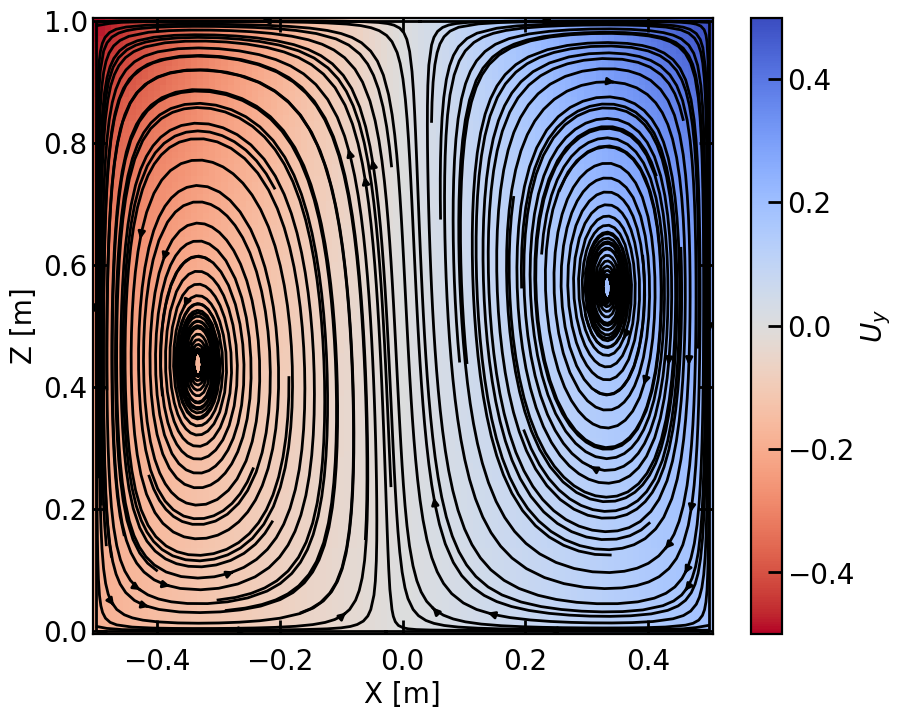

In [6]:
#plot analytical flowfield
flow = 'asymmetric'

fig, ax = plt.subplots()
lonsflow = flowset3D[flow]['lon'].values
latsflow = flowset3D[flow]['lat'].values
depthflow = flowset3D[flow]['depth'].values
depthgrid, latsgrid, longrid= np.meshgrid(depthflow, latsflow, lonsflow, indexing='ij')
Uflow = flowset3D[flow]['U'][0, :, :, :].values
Vflow = flowset3D[flow]['V'][0, :, :, :].values
Wflow = flowset3D[flow]['W'][0, :, :, :].values
speedflow = np.sqrt(Uflow**2 + Vflow**2 + Wflow**2)

ax.streamplot(longrid[:, 50, :], depthgrid[:,50,:], Uflow[:,50,:], Wflow[:,50,:], color='k', broken_streamlines=False)
pcm=ax.pcolormesh(longrid[:, 50, :],depthgrid[:,50,:],Vflow[:,50,:],cmap='coolwarm_r')#,vmin=-0.3,vmax=0.3)
ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")
cbar=fig.colorbar(pcm,label='$U_{y}$')

In [7]:
flow = 'symmetric'
particle_type = 'tracer'
if(particle_type == 'tracer'):
    name_out = '{particle_type}_advection_{flow}_{dim}_RK4.png'.format(particle_type =  particle_type, flow = flow, dim = dim)
else:
    name_out = '{particle_type}_advection_{flow}_{dim}_RK4_B{B:04d}_tau{tau:0.0E}.png'.format(particle_type =  particle_type, flow = flow, dim = dim, B=int(B*1000), tau=Decimal(tau))
nparticles= dataset3D[flow][particle_type].attrs['nparticles']
lonp=dataset3D[flow][particle_type]['lon'].values
latp=dataset3D[flow][particle_type]['lat'].values
depthp=dataset3D[flow][particle_type]['z'].values

tstart=0
dt_write = float(dataset3D[flow][particle_type].attrs['write_dt']) #in seconds
runtime = float(dataset3D[flow][particle_type].attrs['runtime'])# in seconds
tstop=int(runtime / dt_write)

fig = px.scatter_3d()
for n in range(3,nparticles,3):
    fig.add_scatter3d(x=lonp[n,tstart:tstop], y=latp[n,tstart:tstop], z=depthp[n,tstart:tstop])
    if(particle_type == 'tracer'):
        fig.update_traces(marker_size = 3) 
    else:
        fig.update_traces(mode='markers', marker_size = 3) 
    fig.update_layout(
    showlegend=False,
    scene = dict(

    xaxis= dict(title='X [m]', nticks=4,range=[-0.5,0.5],tickfont=dict(size=15),titlefont=dict(size=25)),
    yaxis= dict(title='Y [m]', nticks=4,range=[-0.5,0.5],tickfont=dict(size=15),titlefont=dict(size=25)),
    zaxis= dict(title='Z [m]', nticks=4,range=[0,1.],tickfont=dict(size=15),titlefont=dict(size=25)),
     aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=900,
    margin=dict(r=0, l=0, b=0, t=0),
    paper_bgcolor='rgba(0,0,0,0)',
    scene_camera=dict( center=dict(x=0, y=0, z=-0.25),eye=dict(x=-1.3, y=-1.5, z=0.7)))

fig.show()

# fig.write_image('../figures/'+name_out, width=900, height=450)

In [ ]:
# plot frames for movie 
flow = 'assymetric'
lonpMR = dataset3D[flow]['inertial']['lon'].values[m]
latpMR = dataset3D[flow]['inertial']['lat'].values[m]
depthpMR = dataset3D[flow]['inertial']['z'].values[m]

lonpMRSM = dataset3D[flow]['inertial_SM']['lon'].values[m]
latpMRSM = dataset3D[flow]['inertial_SM']['lat'].values[m]
depthpMRSM = dataset3D[flow]['inertial_SM']['z'].values[m]

for t in range (0,1000,1):
    tstart= t
    tstop=t+1
    fig = px.scatter_3d()
    fig.add_scatter3d(x=lonpMR[tstart:tstop],y=latpMR[tstart:tstop],z=depthpMR[tstart:tstop])
    fig.update_traces( marker_size = 3) # mode='markers',
    fig.update_layout(
        showlegend = False,
        scene = dict(
            xaxis = dict(title='X [m]', nticks=4, range=[-0.5, 0.5], tickfont=dict(size=15), titlefont=dict(size=25)),
            yaxis = dict(title='Y [m]', nticks=4, range=[-0.5, 0.5], tickfont=dict(size=15), titlefont=dict(size=25)),
            zaxis = dict(title='Z [m]', nticks=4, range=[0, 1], tickfont=dict(size=15), titlefont=dict(size=25)),
            aspectratio = dict(x=1, y=1, z=1)
        ),
        width = 900,
        height = 450,
        margin = dict(r=0, l=0, b=0, t=0),
        paper_bgcolor='rgba(0,0,0,0)',
        scene_camera=dict(center=dict(x=0, y=0, z=-0.25), eye=dict(x=-1.3, y=-1.5, z=0.7))
        )

    fig.add_scatter3d(x=lonpMRSM[tstart:tstop], y=latpMRSM[tstart:tstop], z=depthpMRSM[tstart:tstop])
    fig.update_traces( marker_size = 3) # mode='markers',
    fig.update_layout(
        showlegend=False,
        scene = dict(
            xaxis= dict(title='X [m]', nticks=4,range=[-0.5,0.5],tickfont=dict(size=15),titlefont=dict(size=25)),
            yaxis= dict(title='Y [m]', nticks=4,range=[-0.5,0.5],tickfont=dict(size=15),titlefont=dict(size=25)),
            zaxis= dict(title='Z [m]', nticks=4,range=[0,1],tickfont=dict(size=15),titlefont=dict(size=25)),
            aspectratio=dict(x=1, y=1, z=1)       
            ),
        width = 900,
        height = 450,
        margin = dict(r=0, l=0, b=0, t=0),
        paper_bgcolor = 'rgba(0,0,0,0)',
        scene_camera = dict(center=dict(x=0, y=0, z=-0.25), eye=dict(x=-1.3, y=-1.5, z=0.7)))
    # fig.show()
    # fig.write_image("../figures/frames/frame_{:04d}.png".format(t), width=900, height=450)

#make movie from frames using: ffmpeg -framerate 20 -i frame_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 name_movie.mp4